In [1]:
import netCDF4
from scipy import stats
import pyresample
import matplotlib.pyplot as plt
import warnings
import os
import glob
import numpy as np
warnings.filterwarnings('ignore')

/home/alex/anaconda3/envs/torch/lib/python3.8/site-packages/pyresample/bilinear/__init__.py:49: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


# Load Sample Image

In [2]:
dsets = []

files = {
    f.split("_")[2].split("-")[0]: f 
    for f in glob.glob("/home/alex/Datasets/HW8/2019.12.07.10.00/*.nc")
}

In [3]:
r = netCDF4.Dataset(files["B03"])
g = netCDF4.Dataset(files["B02"])
b = netCDF4.Dataset(files["B01"])

In [4]:
data = np.vstack((
    [r["channel_0003_scaled_radiance"][0, :, :]], 
    [g["channel_0002_scaled_radiance"][0, :, :]],
    [b["channel_0001_scaled_radiance"][0, :, :]]
)).transpose(1, 2, 0)

data.shape

(11000, 11000, 3)

In [5]:
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


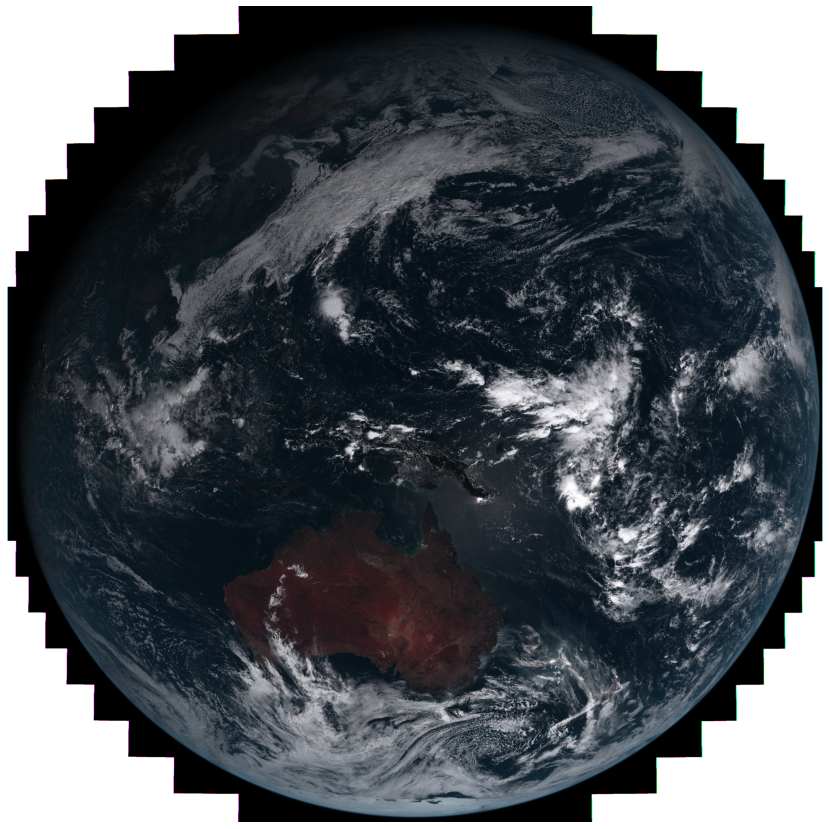

In [6]:
fig = plt.figure(figsize=(15,15))
plt.imshow(data[::5, ::5, :])
plt.axis("off");

In [24]:
from pyproj import Transformer

longlat = "+proj=longlat +datum=WGS84"
hw8 = r.variables["geostationary"].proj4

projector = Transformer.from_proj(proj_from=longlat, proj_to=hw8, always_xy=True)

hw8

'+proj=geos +lon_0=140.7 +h=35785863 +x_0=0 +y_0=0 +a=6378137 +b=6356752.3 +units=m +no_defs '

In [8]:
point = projector.transform(150.5, -34.5)

In [9]:
point

(866588.0284250624, -3464526.0783356354)

In [10]:
proj_point = (
    -int((point[1] - r.variables["y"][0].data.tolist())/1000), 
    int((point[0] - r.variables["x"][0].data.tolist())/1000)
)

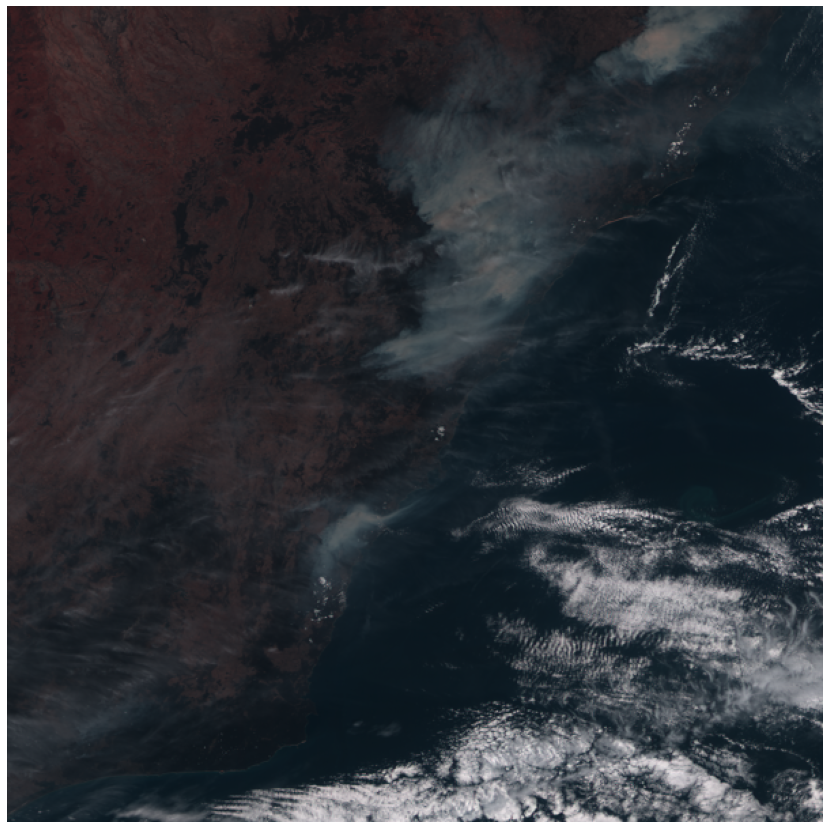

In [11]:
fig = plt.figure(figsize=(15,15))
x = proj_point[0]
y = proj_point[1]
plt.imshow(data[x - 300: x + 300, y - 300: y + 300, :])
plt.axis("off");

The problem here is that in satellite image like this one, regions further from the central point ((140.7, 0) for Himawari 8) are progressively distorted. Apply any convolution-based ML consistently requires treating all regions on the same footing. In analogy to general relativity, a locally flat coordinate system offers a potential solution to this problem.

# Re-project to locally flat coordinates

Locally flat coordinate system

In [12]:
N = 300_000
S = -300_000
E = 300_000
W = -300_000
resolution = 1000

euc_area_def = pyresample.create_area_def(
    'loc_flat_area',
    {
        'proj': 'aeqd', 
        'datum': 'WGS84', 
        'lat_0' : str(-34.5),
        'lon_0' : str(150.5)
    },
    area_extent=[W, S, E, N],
    resolution=resolution,
    units='meters',
    description='Create a locally flat image of an object'
)

Lets verify that in this reference frame, an area of 600x600 km<sup>2</sup> , binned to 1 km resolution.

In [13]:
from sklearn.metrics import pairwise_distances
from geopy.distance import geodesic

In [14]:
np.random.seed(42)

aeqd_points = list(zip(np.random.randint(W, E, 5), np.random.randint(S, N, 5)))

np.round(pairwise_distances(aeqd_points, aeqd_points, metric='euclidean'))

array([[     0.,  83052., 526442., 141042., 120884.],
       [ 83052.,      0., 449710., 136658.,  43625.],
       [526442., 449710.,      0., 446848., 430336.],
       [141042., 136658., 446848.,      0., 172819.],
       [120884.,  43625., 430336., 172819.,      0.]])

In [15]:
aeqd_local = "+proj=aeqd +lat_0=-34.5 +lon_0=150.5 +datum=WGS84"

projector = Transformer.from_proj(proj_from=aeqd_local, proj_to=longlat, always_xy=True)

lonlat_points = list(projector.itransform(aeqd_points))
lonlat_points = [(pt[1], pt[0]) for pt in lonlat_points]

np.round(np.array([geodesic(pt1, pt2).m for pt1 in lonlat_points for pt2 in lonlat_points]).reshape(5, 5))

array([[     0.,  83045., 526437., 141020., 120864.],
       [ 83045.,      0., 449704., 136633.,  43616.],
       [526437., 449704.,      0., 446848., 430325.],
       [141020., 136633., 446848.,      0., 172789.],
       [120864.,  43616., 430325., 172789.,      0.]])

Hence, equidistance coordinate system provides a decent approximation to locally euclidian coordinate reference frame.

# Image in a locally Euclidian-ish coordinates

In order to interpolate sat data to the new coordinate system, initial and final projections have to be defined. There are two ways to do it.

## The longer way

In [16]:
N = 5_500_000
S = -5_500_000
E = 5_500_000
W = -5_500_000

hw8_area_def = pyresample.create_area_def(
    'hw8_area',
    pyresample.utils.proj4.proj4_str_to_dict(r.variables["geostationary"].proj4),
    area_extent=[W, S, E, N],
    resolution=1000,
    units='meters',
    description='Create a Himawari 8 area'
)

print(hw8_area_def)

Area ID: hw8_area
Description: Create a Himawari 8 area
Projection: {'a': '6378137', 'h': '35785863', 'lon_0': '140.7', 'no_defs': 'None', 'proj': 'geos', 'rf': '298.257024882273', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 11000
Number of rows: 11000
Area extent: (-5500000.0, -5500000.0, 5500000.0, 5500000.0)


## The shorter way

In [17]:
hw8_area_def, hw8_area_info = pyresample.utils.load_cf_area(files["B03"])
hw8_area_def

Area ID: geostationary
Description: geostationary
Projection: {'a': '6378137', 'h': '35785863', 'lon_0': '140.7', 'no_defs': 'None', 'proj': 'geos', 'rf': '298.257024882273', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 11000
Number of rows: 11000
Area extent: (-5500000.0, -5500000.0, 5500000.0, 5500000.0)

In [18]:
flat_data = pyresample.kd_tree.resample_nearest(hw8_area_def, data, euc_area_def, radius_of_influence=2000, fill_value=None)

print("Shape: ", flat_data.shape)
print("Type:", flat_data.dtype)

Shape:  (600, 600, 3)
Type: float32


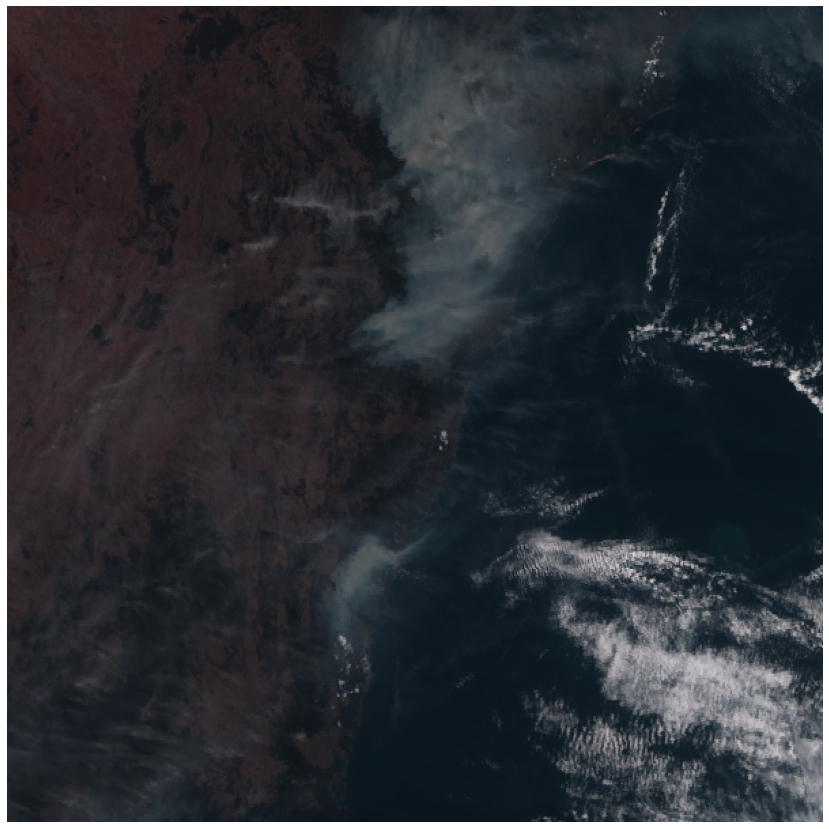

In [19]:
fig1 = plt.figure(figsize=(15,15))
plt.imshow(flat_data)
plt.axis("off");

# Infrared channel
> 3.9 $\mu$m infrared channel provides a good contrast to large scale fires. This channel comes only in a 2 km resolution.

In [20]:
ir4 = netCDF4.Dataset(files["B07"])

In [21]:
hw8_area_def, hw8_cf_info = pyresample.utils.load_cf_area(files["B07"])
hw8_area_def

Area ID: geostationary
Description: geostationary
Projection: {'a': '6378137', 'h': '35785863', 'lon_0': '140.7', 'no_defs': 'None', 'proj': 'geos', 'rf': '298.257024882273', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 5500
Number of rows: 5500
Area extent: (-5500000.0, -5500000.0, 5500000.0, 5500000.0)

In [22]:
ir4_flat_data = pyresample.kd_tree.resample_nearest(hw8_area_def, ir4["channel_0007_brightness_temperature"][0, :, :], euc_area_def, radius_of_influence=4000, fill_value=None)

print("Shape: ", ir4_flat_data.shape)
print("Type:", ir4_flat_data.dtype)

Shape:  (600, 600)
Type: float32


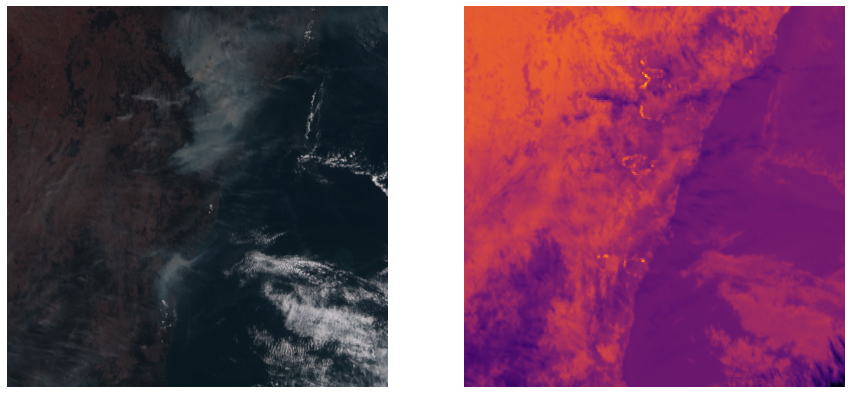

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(flat_data)
axs[1].imshow(ir4_flat_data, cmap="inferno")
axs[0].axis("off")
axs[1].axis("off");